In [ ]:
pip install ensemble_boxes

In [2]:
import cv2
import numpy as np
from ensemble_boxes import *
from pycocotools.coco import COCO
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import matplotlib.patches as patches


In [81]:
# ensemble csv files
csv1 = './submission/htc_swin_base_4620.csv'
model1_name = csv1.split('/')[-1]
csv2 = './submission/epoch_35.csv'
model2_name = csv2.split('/')[-1]
submission_files = [csv1, csv2]
submission_df = [pd.read_csv(file) for file in submission_files]

In [66]:
submission_df

[                                      PredictionString              image_id
 0    1 0.7317413 165.17004 77.046074 254.6896 166.1...  batch_01_vt/0021.jpg
 1    1 0.05205372 0.45411682 247.69443 303.4712 457...  batch_01_vt/0028.jpg
 2    1 0.9981104 69.8728 168.53122 372.3017 378.621...  batch_01_vt/0031.jpg
 3    2 0.44494128 297.60336 157.65466 362.16025 229...  batch_01_vt/0032.jpg
 4    0 0.07382635 87.155045 139.11166 390.45587 269...  batch_01_vt/0070.jpg
 ..                                                 ...                   ...
 832  1 0.62004805 71.01703 154.88377 407.45596 384....     batch_03/0947.jpg
 833  1 0.85909164 319.48254 343.8813 363.6557 504.2...     batch_03/0968.jpg
 834  1 0.98298717 143.07632 81.86799 171.63806 290....     batch_03/0969.jpg
 835  1 0.677259 131.3607 355.60724 152.71861 375.44...     batch_03/0992.jpg
 836  1 0.90714455 0.09643555 0.0 214.47726 71.63718...     batch_03/0998.jpg
 
 [837 rows x 2 columns],
                                     

In [67]:
image_ids = submission_df[0]['image_id'].tolist()

In [68]:
test_dir = '../../input/data/'
annotation = '../../input/data/test.json'
coco = COCO(annotation)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [145]:
# bounding box 확인하기
# color = ['#E89D9D', '#FFADAD', '#FFD6A5', '#FDFFB6', '#CAFFBF', '#9BF6FF', '#A0C4FF', '#BDB2FF', '#FFADFF', '#023E8A', '#03045E']
color = ['#FF595E', '#FFB485', '#F5B400', '#D0D449', '#6A9A1D', '#76BA4F', '#366D4D', '#269BE3', '#324F85', '#7E5DAC', '#792E3F']
classes = ["UNKNOWN", "General trash", "Paper", "Paper pack", "Metal", "Glass",
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

In [118]:
prediction_strings = []
file_names = []
iou_thr = 0.4
weights = [2, 1]

for i, image_id in enumerate(image_ids):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
    for df in submission_df:
        predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()
        if len(predict_list)==0 or len(predict_list)==1:
            continue
        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []
        for box in predict_list[:, 2:6].tolist():
            box[0] = float(box[0]) / image_info['width']
            box[1] = float(box[1]) / image_info['height']
            box[2] = float(box[2]) / image_info['width']
            box[3] = float(box[3]) / image_info['height']
            box_list.append(box)
        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))
    
    if len(boxes_list):
        boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=0.00001)
        for box, score, label in zip(boxes, scores, labels):
            prediction_string += str(int(label)) + ' ' + str(score) + ' ' + str(box[0] * image_info['width']) + ' ' + str(box[1] * image_info['height']) + ' ' + str(box[2] * image_info['width']) + ' ' + str(box[3] * image_info['height']) + ' '
    
    prediction_strings.append(prediction_string)
    file_names.append(image_id)

In [76]:
submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
csv3 = './submission/submission_ensemble_5.csv'
submission.to_csv(csv3, index=False)

submission.head()

,PredictionString,image_id
0,8 0.9995651245117188 173.2920379638672 233.953...,batch_01_vt/0021.jpg
1,8 1.0510143041610718 159.10964965820312 63.907...,batch_01_vt/0028.jpg
2,1 0.998406708240509 69.30735778808594 168.7518...,batch_01_vt/0031.jpg
3,8 1.0624866 35.74962615966797 155.792236328125...,batch_01_vt/0032.jpg
4,1 1.0922116041183472 385.1842041015625 269.363...,batch_01_vt/0070.jpg


In [94]:
# pred1 = pd.read_csv("swin_base_ep11.csv")
pred1 = pd.read_csv(csv1)
pred2 = pd.read_csv(csv2)
pred3 = pd.read_csv(csv3)

# pred1 = pred1.drop("Unnamed: 0", axis = 1)
# pred2 = pred2.drop("Unnamed: 0", axis = 1)
# pred3 = pred3.drop("Unnamed: 0", axis = 1)

In [154]:
def print_img(pred1, pred2, pred3, x):
    img_path = test_dir + pred1['image_id'][x]
#     test_img = cv2.imread(img_path)
    
    test_img = Image.open(img_path)
    img = np.array(test_img)
    
    info1 = pred1.iloc[x][0]
    info1 = info1[:-1]
    info2 = pred2.iloc[x][0]
    info2 = info2[:-1]
    info3 = pred3.iloc[x][0]
    info3 = info3[:-1]
    # def object_box(img, info):
    info1 = info1.split(" ")
    info2 = info2.split(" ")
    info3 = info3.split(" ")
    # info
    i = 0
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (40,20))
    
    while i < len(info1) and i < len(info2) and i < len(info3):
        label1 = int(info1[i])
        score1 = float(info1[i+1])
        x_min1 = float(info1[i+2])
        y_min1 = float(info1[i+3])
        x_max1 = float(info1[i+4])
        y_max1 = float(info1[i+5])
        
        label2 = int(info2[i])
        score2 = float(info2[i+1])
        x_min2 = float(info2[i+2])
        y_min2 = float(info2[i+3])
        x_max2 = float(info2[i+4])
        y_max2 = float(info2[i+5])
        
        label3 = int(info3[i])
        score3 = float(info3[i+1])
        x_min3 = float(info3[i+2])
        y_min3 = float(info3[i+3])
        x_max3 = float(info3[i+4])
        y_max3 = float(info3[i+5])
        ax1.imshow(img)
        ax1.axis('off')
        ax1.set_title(model1_name, loc='left', fontsize=15)
        ax1.add_patch(
             patches.Rectangle(
                (x_min1, y_min1),
                x_max1-x_min1,
                y_max1-y_min1,
                edgecolor = color[label1],
                facecolor = 'red',
                fill=False,
                linewidth=4, 
                alpha=1.0
             ))
        ax1.text(x_min1+1.5, y_min1-5.0, classes[label1], fontsize=15, color = 'white', backgroundcolor=color[label1], alpha=0.5)
        ax2.imshow(img)
        ax2.axis('off')
        ax2.set_title(model2_name, loc='left', fontsize=15)
        ax2.add_patch(
             patches.Rectangle(
                (x_min2, y_min2),
                x_max2-x_min2,
                y_max2-y_min2,
                edgecolor = color[label2],
                facecolor = 'red',
                fill=False,
                linewidth=4, 
                alpha=1.0
             ))
        ax2.text(x_min2+1.5, y_min2-5.0, classes[label2], fontsize=15, color = 'white', backgroundcolor=color[label2], alpha=0.5)
        ax3.imshow(img)
        ax3.axis('off')
        ax3.set_title('result', loc='left', fontsize=15)
        ax3.add_patch(
             patches.Rectangle(
                (x_min3, y_min3),
                x_max3-x_min3,
                y_max3-y_min3,
                edgecolor = color[label3],
                facecolor = 'red',
                fill=False,
                linewidth=4, 
                alpha=1.0
             ))
        ax3.text(x_min3+1.5, y_min3-5.0, classes[label3], fontsize=15, color = 'white', backgroundcolor=color[label3], alpha=0.5)
        i += 6
#         break
    plt.show()

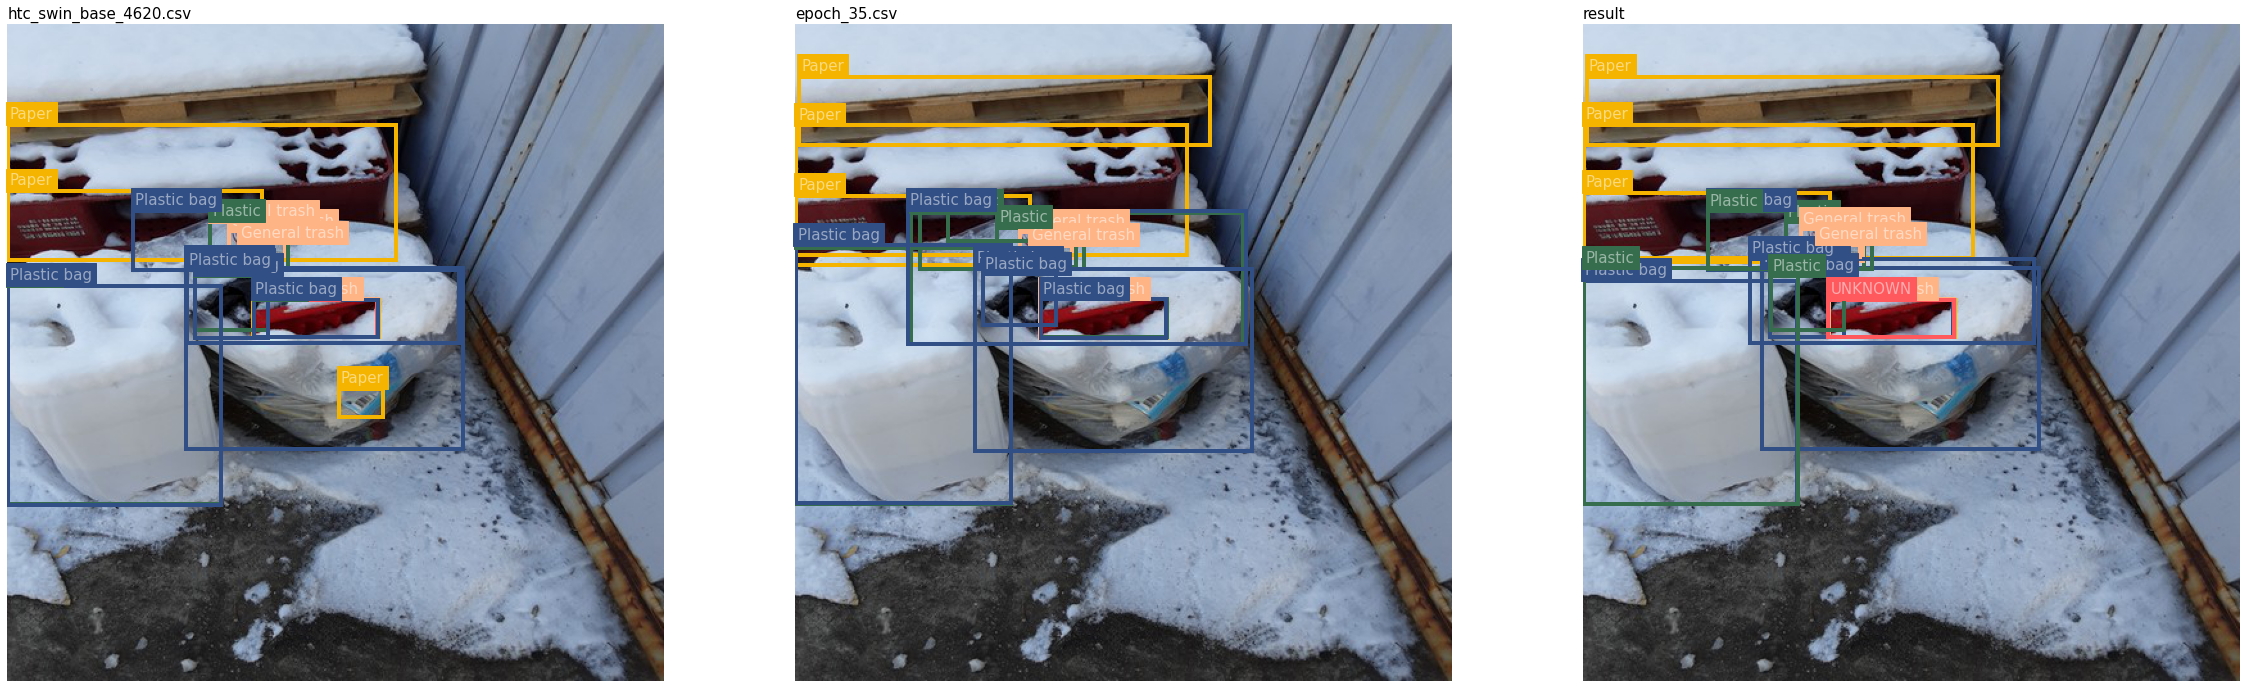

In [155]:
print_img(pred1, pred2, pred3, 20)

In [ ]:
# i = 0
# iou_thr = 0.5
# skip_box_thr = 0.0001
# sigma = 0.1
# weights = None
# boxes, scores, labels = nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr)
# boxes, scores, labels = soft_nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
# boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
# boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)


# boxes0, scores0, labels0 = nms([whole_bbox[i]], [whole_prop[i]], [whole_label[i]], weights=[0, 1], iou_thr=iou_thr)
# boxes1, scores1, labels1 = soft_nms([whole_bbox[i]], [whole_prop[i]], [whole_label[i]], weights=weights, iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
# boxes2, scores2, labels2 = non_maximum_weighted([whole_bbox[i]], [whole_prop[i]], [whole_label[i]], weights=weights, iou_thr=iou_thr, skip_box_thr=0.0)
# boxes3, scores3, labels3 = weighted_boxes_fusion([whole_bbox[i]], [whole_prop[i]], [whole_label[i]], weights=weights, iou_thr=iou_thr, skip_box_thr=0.0)

In [ ]:
# whole_bbox = []
# whole_label = []
# whole_prop = []
# for k in range(len(image_bbox)):
#     img_bbox = []
#     label = []
#     prop = []
#     prediction_list = image_bbox[k].split()
#     i = 0
#     while i < len(prediction_list):
#         if i % 6 == 0:
#             bbox = []
#             label.append(int(prediction_list[i]))
#         elif i % 6 == 1:
#             prop.append(float(prediction_list[i]))
#         else:
#             bbox.append(float(prediction_list[i]))
#         i += 1
#         if i % 6 == 0:
#             img_bbox.append(bbox)
#     whole_bbox.append(list(img_bbox))
#     whole_label.append(list(label))
#     whole_prop.append(list(prop))